In [257]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows',None)

import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import scipy
from skmultiflow.drift_detection import DDM, EDDM
from datetime import datetime

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [258]:
df_main = pd.read_csv("/mnt/c/Users/Asus1/jupyter-lab/New_research_prashanth_sir_code_files/resampled_dataset.csv")
df_main.head(10)

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Type_L,Type_M,Machine failure
0,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,1,0
1,298.2,308.7,1408,46.3,3,0,0,0,0,0,1,0,0
2,298.1,308.5,1498,49.4,5,0,0,0,0,0,1,0,0
3,298.2,308.6,1433,39.5,7,0,0,0,0,0,1,0,0
4,298.2,308.7,1408,40.0,9,0,0,0,0,0,1,0,0
5,298.1,308.6,1425,41.9,11,0,0,0,0,0,0,1,0
6,298.1,308.6,1558,42.4,14,0,0,0,0,0,1,0,0
7,298.1,308.6,1527,40.2,16,0,0,0,0,0,1,0,0
8,298.3,308.7,1667,28.6,18,0,0,0,0,0,0,1,0
9,298.5,309.0,1741,28.0,21,0,0,0,0,0,0,1,0


Total dataset size :  19322
Number of machine failures (1) :  9661
Number of machine sucesses (0) :  9661


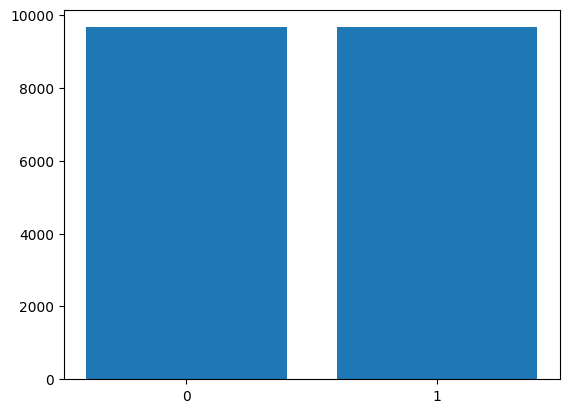

In [259]:
plt.bar(["0","1"], [len(df_main[df_main["Machine failure"] == 1]), len(df_main[df_main["Machine failure"] == 0])])
print("Total dataset size : ", len(df_main))
print("Number of machine failures (1) : ", len(df_main[df_main["Machine failure"] == 1]))
print("Number of machine sucesses (0) : ", len(df_main[df_main["Machine failure"] == 0]))

In [260]:
def dependent_independent_split(dataset):
    y = dataset["Machine failure"].to_numpy()
    X = dataset.iloc[:,:12].to_numpy()
    return X, y

In [261]:
X,y = dependent_independent_split(df_main)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7 , test_size = 0.3, )

In [285]:
len(X_train)

13525

In [293]:
model = tf.keras.Sequential([
    
    Dense(units = 12,activation = "relu",input_dim = len(df_main.columns.tolist()[:-1])),
    Dense(units = 25,activation = "relu",),
    Dense(units = 50,activation = "relu",),
    Dense(units = 25,activation = "relu",),
    Dense(units = 12,activation = "relu",),
    
    Dense(units = 1, activation = "sigmoid")
])
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_132 (Dense)               │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 25)             │           325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 50)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 12)             │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,381 (13.21 KB)

 Trainable params: 3,381 (13.21 KB)

 Non-trainable params: 0 (0.00 B)

In [294]:
opt = Adam(
            learning_rate=0.001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07,
            amsgrad=False,
            weight_decay=None,
            clipnorm=None,
            clipvalue=None,
            global_clipnorm=None,
            use_ema=False,
            ema_momentum=0.99,
            ema_overwrite_frequency=None,
            loss_scale_factor=None,
            gradient_accumulation_steps=None,
        )
loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=False,
            label_smoothing=0.0,
            axis=-1,
        )
model.compile(optimizer = opt, loss = loss, metrics = ["acc"])

In [295]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
with tf.device('/gpu:0'):
    history = model.fit(x = X_train, y = y_train,  epochs = 50, verbose = 1, callbacks=[tensorboard_callback])

Epoch 1/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - acc: 0.6568 - loss: 2.5402
Epoch 2/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7617 - loss: 0.5485
Epoch 3/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7722 - loss: 0.5371
Epoch 4/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8018 - loss: 0.4661
Epoch 5/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8336 - loss: 0.3852
Epoch 6/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8497 - loss: 0.3415
Epoch 7/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8545 - loss: 0.3416
Epoch 8/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8560 - loss: 0.3475
Epoch 9/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8678 - loss: 0.3162
Epoch 10/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.8822 - loss: 0.2839
Epoch 11/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.8788 - loss: 0.2899
Epoch 12/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.8800 - loss: 0.2807
Epoch 13/50
423/423 ━━━━━

In [221]:
%tensorboard --logdir logs/scalars

['Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'TWF',
 'HDF',
 'PWF',
 'OSF',
 'RNF',
 'Type_L',
 'Type_M']

In [230]:
np.transpose(X_test).shape

(12, 5797)

In [247]:
y_pred = model.predict(X_test)
labels = tf.constant(y_test,dtype = tf.int32)
predictions = tf.constant(y_pred,dtype = tf.int32)
cm = tf.math.confusion_matrix(
    labels,
    predictions,
    num_classes=2
)

confusion_table = PrettyTable()
confusion_table.field_names = ["class", "0", "1"]
confusion_table.add_row(["0"]+ cm.numpy().tolist()[0])
confusion_table.add_row(["1"]+ cm.numpy().tolist()[1])

confusion_table

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step


class,0,1
0,2907,0
1,1028,1862


In [238]:
cm.numpy().tolist()

[[2907, 0], [1028, 1862]]

In [197]:
# y_pred = model.predict(X_test)
# accuracy = model.loss(y_pred, y_test)

# print("Accuracy : ", accuracy)

In [198]:
loss_train, train_acc = model.evaluate(X_test, y_test, verbose = 0)

In [199]:
y_test.shape

(5797,)

In [200]:
def create_simple_drift(X, y, number_of_datasets = 1, offset = 1.0):
    dataset_dict = {}
    temp_x_list = []
    
    for i in range(number_of_datasets-1):
        iterr = 0
        temp_x_list = []
        for j in range(len(X[1,:])):
            temp_x = np.array([0])
            if j % 2 == 0 :
                temp_x = X[:,j] * offset * i+1
                temp_x_list.append(temp_x.tolist())
            else:
                temp_x = X[:,j]
                temp_x_list.append(temp_x.tolist())
            
        dataset_dict[i] = [temp_x_list, y]
    return dataset_dict

In [201]:
d = create_simple_drift(X_test,y_test, 3, offset = 2)

In [210]:
X_drift_test = np.transpose(np.array(d[0][0]))
y_drift_test = np.array(d[0][1])

X_drift_test1 = np.transpose(np.array(d[1][0]))
y_drift_test1 = np.array(d[1][1])

loss_test1, test1_acc = model.evaluate(X_drift_test, y_drift_test, verbose = 0)
loss_test2, test2_acc = model.evaluate(X_drift_test1, y_drift_test1, verbose = 0)

In [203]:
similarity1 = scipy.stats.kstest(X_test, X_drift_test)[0].tolist()
similarity2 = scipy.stats.kstest(X_test, X_drift_test1)[0].tolist()
similarity1 = [round(elem, 3) for elem in similarity1]
similarity2 = [round(elem, 3) for elem in similarity2]

In [204]:
ttest1 = scipy.stats.ttest_ind(a=X_test, b=X_drift_test, equal_var=True)[0].tolist()
ttest2 = scipy.stats.ttest_ind(a=X_test, b=X_drift_test1, equal_var=True)[0].tolist()
ttest1 = [round(elem, 3) for elem in ttest1]
ttest2 = [round(elem, 3) for elem in ttest2]

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:605: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [205]:
jb_org1 = X_test.tolist()
jb_set1 = X_drift_test.tolist()
for i in jb_set1:
    jb_org.append(i)

jb_org2 = X_test.tolist()
jb_set2 = X_drift_test1.tolist()
for i in jb_set2:
    jb_org2.append(i)

In [206]:
np.array(jb_org2)[:,0]
jbtest1 = []
jbtest2 = []
for i in range(len(np.array(jb_org2)[1])):
    jbtest1.append(round(scipy.stats.jarque_bera(np.array(jb_org1)[:,i])[0], 3))
    jbtest2.append(round(scipy.stats.jarque_bera(np.array(jb_org2)[:,i])[0],3))

In [207]:
from prettytable import PrettyTable
table1 = PrettyTable()

table1.field_names = ["Statistics"] + df_main.columns.tolist()[:-1]
table1.add_row(["KS_stat"] + similarity1)
table1.add_row(["Double_T_test"] + ttest1)
table1.add_row(["JB_test"] + jbtest1)

table2 = PrettyTable()

table2.field_names = ["Statistics"] + df_main.columns.tolist()[:-1]
table2.add_row(["KS_stat"] + similarity2)
table2.add_row(["Double_T_test"] + ttest2)
table2.add_row(["JB_test"] + jbtest2)

In [208]:
table1

Statistics,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Type_L,Type_M
KS_stat,1.0,0.0,1.0,0.0,0.991,0.0,0.87,0.0,0.883,0.0,0.448,0.0
Double_T_test,11593.18,-0.0,398.651,-0.0,131.193,0.0,-197.04,0.0,-209.19,0.0,-68.537,0.0
JB_test,268.54,55.872,22469.698,236.852,432.148,100758.261,6642.737,19992.475,8766.003,505219433.804,966.642,2571.209


In [209]:
table2

Statistics,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Type_L,Type_M
KS_stat,1.0,0.0,0.96,0.0,0.521,0.0,0.87,0.0,0.883,0.0,0.552,0.0
Double_T_test,-5219.257,-0.0,-178.518,-0.0,-59.638,0.0,-114.429,0.0,-118.335,0.0,-106.29,0.0
JB_test,1929.06,111.743,1757.905,473.704,843.474,201516.522,6591.935,39984.949,7102.211,1010438867.609,1157.846,5142.418


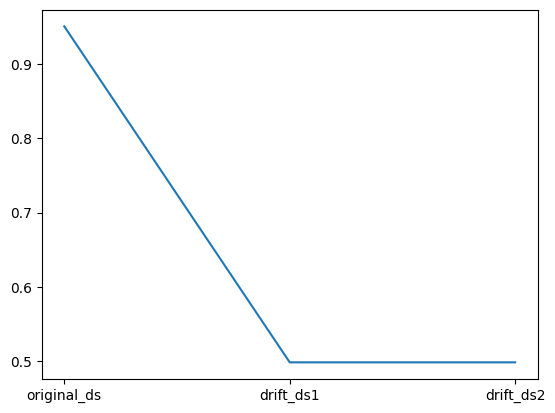

In [211]:
y = []
y.append(train_acc)
y.append(test1_acc)
y.append(test2_acc)

X = ["original_ds", "drift_ds1", "drift_ds2"]
plt.plot(X, y)

In [563]:
ddm = DDM(min_num_instances=30, warning_level=1.0, out_control_level=1.0)
h = X_test[:, 0] + X_drift_test[:, 4]
for i in h:
    ddm.add_element(i)
    if ddm.detected_warning_zone():
        print('Warning zone has been detected in data: ' + str(data_stream[i]) + ' - of index: ' + str(i))
    if ddm.detected_change():
        print('Change has been detected in data: ' + str(data_stream[i]) + ' - of index: ' + str(i))

In [249]:
ddm = EDDM()
h = X_test[:, 0] + X_drift_test[:, 4]
for i in h:
    ddm.add_element(i)
    if ddm.detected_warning_zone():
        print('Warning zone has been detected in data: ' + str(data_stream[i]) + ' - of index: ' + str(i))
    if ddm.detected_change():
        print('Change has been detected in data: ' + str(data_stream[i]) + ' - of index: ' + str(i))

In [568]:
import numpy as np
from skmultiflow.drift_detection import DDM
ddm = EDDM()
# Simulating a data stream as a normal distribution of 1's and 0's
data_stream = np.random.randint(2, size=2000)
# Changing the data concept from index 999 to 1500, simulating an 
# increase in error rate
for i in range(999, 1500):
    data_stream[i] = 0
# Adding stream elements to DDM and verifying if drift occurred
for i in range(2000):
    ddm.add_element(data_stream[i])
    if ddm.detected_warning_zone():
        print('Warning zone has been detected in data: ' + str(data_stream[i]) + ' - of index: ' + str(i))
    if ddm.detected_change():
        print('Change has been detected in data: ' + str(data_stream[i]) + ' - of index: ' + str(i))

Change has been detected in data: 1 - of index: 56
Warning zone has been detected in data: 1 - of index: 129
Warning zone has been detected in data: 0 - of index: 130
Warning zone has been detected in data: 0 - of index: 131
Warning zone has been detected in data: 0 - of index: 132
Warning zone has been detected in data: 1 - of index: 163
Warning zone has been detected in data: 0 - of index: 164
Warning zone has been detected in data: 1 - of index: 165
Warning zone has been detected in data: 1 - of index: 166
Warning zone has been detected in data: 1 - of index: 167
Warning zone has been detected in data: 0 - of index: 168
Warning zone has been detected in data: 0 - of index: 169
Warning zone has been detected in data: 1 - of index: 170
Warning zone has been detected in data: 0 - of index: 171
Warning zone has been detected in data: 0 - of index: 172
Warning zone has been detected in data: 1 - of index: 173
Warning zone has been detected in data: 1 - of index: 174
Warning zone has been

In [572]:
import hddm

# Load data from csv file into a NumPy structured array
data = hddm.load_csv('simple_difficulty.csv')

# Create a HDDM model multi object
model = hddm.HDDM(data, depends_on={'v':'difficulty'})

# Create model and start MCMC sampling
model.sample(2000, burn=20)

# Print fitted parameters and other model statistics
model.print_stats()

# Plot posterior distributions and theoretical RT distributions
model.plot_posteriors()
model.plot_posterior_predictive()

ModuleNotFoundError: No module named 'hddm'